## TRAINING AUGMENTED INTERPOLATION 

In [280]:
import os


import torch
import torch.nn as nn
from torch.autograd import Variable

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

torch loaded; device is cpu


# PINNs Advection Equation

This notebook solves the advection-diffusion equation using a physics-informed neural network (PINN). The equation is given by:

\begin{cases}
\partial_t u + a \partial_x u = 0 \\
u(t=0, x) = u_0(x, \mu)
\end{cases}

where $u$ is the dependent variable, $t$ is time, $x$ is space, and $a$ is the diffusion coefficient (velocity) The initial condition is given by:

\begin{equation}
u_0(x) = \exp(-(x-\mu)^2/\sigma)
\end{equation}

Where $\mu$ is the mean and $\sigma$ is the variance. The solution is given by:

\begin{equation}
u(x,t) = u_0(x-a*t)
\end{equation}

## Analysis:

### Neural Network
A neural network is a function that maps an input $X$ to an output $Y$ by performing successive linear and nonlinear transformations. The linear transformations are represented by a set of weights $W$ and biases $b$ and the nonlinear transformations are represented by activation functions $\sigma$. The output of a neural network is given by:

$$\overline{u_\theta}(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

We will train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset. 

### Physics Informed Neural Network = NN + PDE

We can use a neural network to approximate any function (Universal Approximation Theorem). In our case, we want to approximate the solution of a PDE. We can do this by minimizing the error of the PDE in a certain number of points inside our domain.

$$\overline{u_\theta}\approx u(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial \overline{u_\theta}}{\partial t},\frac{\partial \overline{u_\theta}}{\partial x}$.

We assume then: $$\overline{u_\theta}(x,t)\approx u(x,t,\theta)$$ 

Then:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a \frac{\partial \overline{u_\theta}}{\partial x}\right) \approx \left(\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x}\right) =0$$

And:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a\frac{\partial \overline{u_\theta} }{\partial x}\right) \approx 0$$

We should also define the boundary conditions both in space and time as it follows:

boundary conditions in space:

$$bc_{space}(x)=x*(x-1)$$

boundary conditions in time:
$$bc_{time}(t)=t$$

Now we can define this function as $u_\theta$:

$${u_\theta}(x,t)= u_{0}(x)+ bc_{time}(t) * bc_{space}(x) * \overline{u_\theta}(x,t)$$ 

If $u_\theta \rightarrow 0$ then our $\overline{u_\theta}$ would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_{coll}$) inside our domain $(x,t)$, and we try also to guess the values of $\mu$ and $\sigma$ of our initial condition adding also collocation points to these parameters ($N_{\mu}$ and $N_{\sigma}$). 

Then we iteratively minimize a loss function related to $u_\theta$:

$$MSE_{u_\theta}=\frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i,\mu_{coll}^i,\sigma_{coll}^i)|^2$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u_{exact}}=\frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|u(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i
)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u_{exact}}+MSE_{u_\theta}$$

We are looking to minimize:
$$
\Theta* = argmin_\Theta \left\{ \frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i,\mu_{coll}^i,\sigma_{coll}^i)|^2 + \frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|u(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i
)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i)|^2 \right\} $$

where $u_\theta$ is the PDE and $u$ is the exact solution.

## Neural Network 

In [281]:
class Net(nn.DataParallel): 
    
    """Defines the neural network model"""
    def __init__(self):
        
        super(Net, self).__init__(nn.Module)
        self.hidden_layer1 = nn.Linear(4, 30).double() 
        self.hidden_layer2 = nn.Linear(30, 30).double()
        self.hidden_layer3 = nn.Linear(30, 30).double()
        self.hidden_layer4 = nn.Linear(30, 10).double()
        self.output_layer = nn.Linear(10, 1).double()

    """Defines the sequence of operations that are applied to the input tensors to produce the output of the neural network"""
    def forward(self, x, t, mean, variance):
    
        inputs = torch.cat([x,t,mean,variance], axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)
        return output


def network_BC(t): #t to define u_theta
    return t 

### Parameters

In [282]:
class Parameters:
   def __init__(self, tf, file_name):
        self.xmin = 0.
        self.xmax = 1.
        self.tmin = 0.
        self.tmax = tf
        self.a = 1.
        self.learning_rate = 1e-3
        self.file_name = file_name
        self.min_mean = 0.4
        self.max_mean = 0.6
        self.min_variance = 0.01
        self.max_variance = 0.2
     
   def u0(self,x,mean,variance):
        return torch.exp(-(x-mean)**2/variance)

## PINN

In [283]:
class Network:

    def __init__(self,param: Parameters):
        """Initializes the neural network model"""
        self.parameters = param 
        self.x_min, self.x_max = param.xmin, param.xmax
        self.t_min, self.t_max = param.tmin, param.tmax
        self.learning_rate = param.learning_rate
        self.u0 = param.u0
        self.tf = param.tmax
        self.a = param.a
        self.file_name = param.file_name
        self.min_mean, self.max_mean = param.min_mean, param.max_mean
        self.min_variance, self.max_variance = param.min_variance, param.max_variance
   
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #returns the current working directory
        self.load(self.file_name)

    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = nn.DataParallel(Net()).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate) #optimization algorithm
   
    def load(self, file_name):
        self.loss_history = []
        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t, mean, variance):

        u = self.u0(x, mean, variance) + network_BC(t) * self(x, t, mean, variance)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # it enables the creation of a computational graph for the gradients. A computational graph is a data structure that represents the operations performed on tensors and their dependencies, which allows for automatic differentiation and backpropagation.
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] #(automatic)
        
        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t, mean, variance): # x tensor pour lequel on calcule la solution, t float, u0 float qu'on converti en tensor 
        ones = torch.ones(x.shape, dtype=torch.double, device=device)
        pt_mean = mean * ones
        pt_variance = variance * ones
        pt_t = t * ones
        pred = self.u0(x, pt_mean, pt_variance) + network_BC(pt_t) * self(x, pt_t, pt_mean, pt_variance)

        return pred

    #Pour l'instant c'est pas utilisé
    """This method predicts the value of u for a given input x and a mesh object"""
    def predict_u(self, x, t, mesh): # x float t float mesh object

        #We need to reshape the input x to be a column vector
        reshaped_x = x.reshape((x.size, 1))
        pt_x = Variable(torch.from_numpy(reshaped_x).double(), requires_grad=True).to(device)
        reshaped_t = t.reshape((x.size, 1))
        pt_t = Variable(torch.from_numpy(reshaped_t).double(), requires_grad=False).to(device)

        u_pred = self.u0(pt_x) + network_BC(pt_t) * self(pt_x, pt_t)

        return u_pred.detach().cpu().numpy().reshape(x.shape)
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)
        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)
        self.mean_data = Network.random(self.min_mean, self.max_mean, shape)
        self.variance_data = Network.random(self.min_variance, self.max_variance, shape)
        
        self.u_data_exact = Network.u_exact(self.x_data, self.t_data, self.a ,self.x_max, self.u0, self.mean_data, self.variance_data) # la solution exacte evaluée dans (xi,ti)
        self.zeros1 = torch.zeros(shape, dtype=torch.double, device=device) 
        
    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        #These variables will be used to evaluate the PDE at the collocation points.
        #collocation points are additional points where the PDE will be evaluated to ensure that the neural network solution satisfies the PDE
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)
        self.mean_collocation = Network.random(self.min_mean, self.max_mean, shape, requires_grad=True)
        self.variance_collocation = Network.random(self.min_variance, self.max_variance, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) #This will be used as a target for the PDE constraints.

    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, epochs, n_collocation, n_data):

        mse_cost_function = torch.nn.MSELoss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):

            self.optimizer.zero_grad()

            self.loss = 0


            if n_collocation > 0:
                # Loss based on PDE constraints
        
                self.make_collocation(n_collocation)
                f_out = self.pde(self.x_collocation, self.t_collocation, self.mean_collocation, self.variance_collocation)
                mse_f = mse_cost_function(f_out, self.zeros)
                self.loss += mse_f
            

            if n_data > 0:
                # Loss based on data fitting (on apprend que avec des donées)
                self.make_data(n_data)
                u_pred = self.predict_u_from_torch(self.x_data, self.t_data, self.mean_data, self.variance_data) #reseau evaluée dans (xi,ti)
                #on essaie de minimizer la différence entre la solution exacte et la solution du réseau calculées en (xi,ti)
                mse_data = mse_cost_function(u_pred, self.u_data_exact) 
                
                self.loss += mse_data

            """Losses based on a combination of PDE constraints in the interior and boundary conditions""" 

            """data points"""
            xmin_tensor = torch.full(self.x_data.size(), self.x_min, dtype=torch.double, device=device, requires_grad=True)
            xmax_tensor = torch.full(self.x_data.size(), self.x_max, dtype=torch.double, device=device, requires_grad=True)
            tmin_tensor = torch.full(self.t_data.size(), self.t_min, dtype=torch.double, device=device, requires_grad=True)
            tmax_tensor = torch.full(self.t_data.size(), self.t_max, dtype=torch.double, device=device, requires_grad=True)
          
            """To enforce the boundary conditions, we evaluate the neural network solution at the boundary points and compare it to the boundary values."""
            #boundary (periodicity) in x
            f_boundary1 = self.predict_u_from_torch(xmin_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundary2 = self.predict_u_from_torch(xmax_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundaryx= torch.abs(f_boundary1 - f_boundary2)
            mse_f_boundaryx = mse_cost_function(f_boundaryx, self.zeros1)

            #boundary (periodicity) in t
            f_boundary3 = self.predict_u_from_torch(self.x_data, tmin_tensor, self.mean_data, self.variance_data)
            f_boundary4 = self.predict_u_from_torch(self.x_data, tmax_tensor, self.mean_data, self.variance_data)
            f_boundaryt= torch.abs(f_boundary3 - f_boundary4)
            mse_f_boundaryt = mse_cost_function(f_boundaryt, self.zeros1)

            #Initial condition
            f_initial = self.predict_u_from_torch(self.x_data, self.t_min, self.mean_data, self.variance_data)
            f_initial_real= self.u0(self.x_data, self.mean_data, self.variance_data)
            f_initiale = torch.abs(f_initial - f_initial_real)
            mse_f_initial = mse_cost_function(f_initiale, self.zeros1)

            self.loss += mse_f_initial + mse_f_boundaryx + mse_f_boundaryt  

            #on fait la backpropagation et on met à jour les poids
            self.loss.backward() # This is for computing gradients using backward propagation
            self.optimizer.step() #This is equivalent to the update step in the gradient descent algorithm
          

            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)

        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, xmax, u0, mean, variance, device=device):
        return u0((x - a * t) % xmax, mean, variance)
    
    
    def plot(self, t, mean, variance):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 10000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]
            # mean = (self.x_min + self.x_max) / 2
            # variance = (self.x_max - self.x_min) / 2
        
            u_pred = self.predict_u_from_torch(x, t, mean, variance)
            u_exact = Network.u_exact(x, t, self.a, self.x_max, self.u0, mean, variance)

            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="Exact solution")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="Prediction (NN)")
            ax[1].set_title("Prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("Prediction error")

    #To save the solution in the form of a .gif file
    def animate(self, mean, variance):
        nb_points = 100
        x = torch.linspace(self.x_min, self.x_max, nb_points, dtype=torch.double, device=device)[:, None]
        t = torch.linspace(self.t_min, self.t_max, nb_points, dtype=torch.double, device=device)[:, None]
                
        """u exact"""
        u_exact = np.zeros((nb_points, nb_points))
        for i in range(nb_points):
            for j in range(nb_points):
                u_exact[i,j] = Network.u_exact(x[i], t[j], self.a, self.x_max, self.u0, mean, variance)

        """prediction"""

        u = np.zeros((nb_points, nb_points))
        for i in range(nb_points):
            u[i, :] = self.predict_u_from_torch(x, t[i], mean, variance).detach().cpu().numpy().flatten()

        fig, ax = plt.subplots()
        line, = ax.plot([], color='red', label='numerical solution')
        line_exact1, = ax.plot([], color='blue', label='exact solution')
        ax.grid()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('x')
        ax.set_ylabel('u')
        ax.set_title('Solution of the advection equation')
        ax.legend()

        def animate(frame_num):
            line.set_data(x, u[frame_num, :])
            line_exact1.set_data(x, u_exact[frame_num, :])
            return line, line_exact1

        anim = FuncAnimation(fig, animate, frames=nb_points, interval=120, blit=True)
        anim.save("animation" + str(mean) + ".gif", writer='pillow')

   

## Implementation of the code

In [284]:
# if __name__ == "__main__":

#     file_name = "test_nuevecito20.pth" #"test_nue22.pth"  nouveau test_nuevecito62 ok 
#     params= Parameters(tf=1., file_name=file_name)
#     network = Network(params)

#     if device.type == "cpu": 
#         network.train(epochs=1500, n_collocation=20000, n_data=50000) #with the two
#         #network.train(epochs=1500, n_collocation=0, n_data=100000) #avec data fitting (supervisé) ok The error is smaller but the prediction is not as good as with the collocation points

#     else:
#         network.train(epochs=1500, n_collocation=100000, n_data=100000) #GPU ok

In [285]:
# network.plot(0.0, 0.5, 0.09)

In [286]:
# network.plot(0.1, 0.5, 0.09)

In [287]:
# network.plot(0.25, 0.5, 0.09)

In [288]:
# network.plot(0.75, 0.5, 0.09)

In [289]:
# network.plot(1., 0.5, 0.09)

## Another solution 


In [290]:
#network.plot(0.0, 0.412, 0.025)

In [291]:
#network.plot(0.5, 0.412, 0.025)

In [292]:
#network.plot(0.75, 0.412,0.025)

In [293]:
#network.plot(1.0, 0.412, 0.025)

In [294]:
# network.animate(0.5, 0.09)

### Semi Lagrangian solver class

In [298]:
"""A function that will create the mesh"""

def mesh (xmin, xmax, tmin, tmax, nx, nt, order):
    x = np.linspace(xmin, xmax, nx, endpoint=True)
    t = np.linspace(tmin, tmax, nt, endpoint=True)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    return x, t, dx, dt

class SemiLagrangianSolver:

    def __init__(self, xmin, xmax, tmin, tmax, nx, nt, a, order):
        
        self.xmesh, self.tmesh, self.delta_x, self.delta_t = mesh(xmin, xmax, tmin, tmax, nx, nt, order)
        
        # self.xmesh, self.tmesh = mesh(xmin, xmax, tmin, tmax, nx, nt, order)

        self.xmax = xmax
        self.xmin = xmin
        self.tmax = tmax
        self.a = a #velocity
        self.nt=nt
        self.nx=nx
        self.u = np.zeros((nt, nx))
        self.u_deep = np.zeros((nt, nx))
        self.order=order
        self.mean = 0.5
        self.variance = 0.09
    
    """Function that defines the u(t=0, x) initial condition"""

    def u_0(self, x):
        return np.exp(-(x-self.mean)**2/self.variance)
    

    """Function that calculates the explicit solution of the transport equation"""
    def explicit_solution(self, x, t): 
        return self.u_0((x - self.a * t) % self.xmax)


    """Function that calculates the closest points to the point x_star (phantom point) 
       based on the x_i point and returns the indexes and the x_star point"""

    def find_closest(self, index):
        # We first calculate the x_star point
        x_i = self.xmesh[index]
        # We take into account the periodicity of the domain
        x_star = (x_i - self.a * self.delta_t) % self.xmax
    
        # We calculate the k index so that x_star is in between x_k and x_{k+1}
        k = int(x_star / self.delta_x)
        #We calculate the other indexes based on k and the order
        indexes = np.zeros(self.order+1, dtype=int)
        indexes = np.arange(k - (self.order//2), k + (self.order//2) + 2)
        indexes = np.mod(indexes, self.nx)
        return indexes, x_star


    """Function that calculates the Lagrange basis polynomial Li at x_star"""
    def Li(self, x_star, x_closest, i):
        result = 1.0
        for j in range(len(x_closest)):
            if j != i:
                result *= (x_star - x_closest[j]) / (x_closest[i] - x_closest[j])
        return result

    """Function that calculates the numerical solution of the Transport equation 
       using de Lagrange interpolation operator"""
 
    def solver(self): #We calculate for t+1 at index index i the mesh at that time 

        self.u[0,:] = self.u_0(self.xmesh)
        
        #We calculate the solution for each time step and each x_i point
        for t in range(self.nt-1):
            for i in range(self.nx):
                # We calculate the closest points to x_star
                closest_indexes, x_star = self.find_closest(i)
                # We retrieve the closest points in our mesh
                x_closest = self.xmesh[closest_indexes]
                # We retrieve the solution at the closest pointsat the time t
                u_closest = self.u[t, closest_indexes]
        
                li = np.zeros(self.order+1)
                for j in range(self.order+1):
                    li[j] = self.Li(x_star, x_closest, j)
                u_sol = np.sum(u_closest*li)
                self.u[t+1,i] = u_sol   
        print(self.u)
        return self.u
       
    def train_PINNs(self, filename, epocs, n_collocation, n_data):

        self.params= Parameters(tf=self.tmax, file_name=filename)
        self.network = Network(self.params)
        self.network.train(epocs, n_collocation, n_data)

    """u_thetai function""" #changer ce solution pour la solution trouvee par le reseau de neurones
    def u_theta(self, x, t):
        pred= self.network.predict_u_from_torch(x, t, self.mean, self.variance)
        return pred.detach().cpu().numpy() #.flatten()

    """Function that calculates using the Deep Lagrange interpolation the numerical solution of the transport equation"""

    def solver_deep(self):
        self.u_deep[0,:] = self.u_0(self.xmesh)

        for t in range(self.nt-1):
            for i in range(self.nx):
                print("t=", t, "i=", i)
                closest_indexes, x_star = self.find_closest(i)
                x_closest = self.xmesh[closest_indexes]
                x_closest = x_closest.reshape(-1, 1)
                print("x_closest",x_closest)
                x_closest = torch.tensor(x_closest, dtype=torch.float32)
                u_closest = self.u_deep[t, closest_indexes]
                u_theta_i = self.u_theta(x_closest, self.tmesh[t])
                print("sol exacte", self.explicit_solution(x_closest, self.tmesh[t]))
                print("sol approchee", u_theta_i)
                u_closest_theta = u_closest / u_theta_i

                li = np.zeros(self.order+1)
                for j in range(self.order+1):
                    li[j] = self.Li(x_star, x_closest, j)
                    x_star_tensor = torch.tensor(x_star.reshape(-1, 1), dtype=torch.float32).clone().detach()
                    u_theta = self.u_theta(x_star_tensor, self.tmesh[t])
                    print("u_theta", u_theta)
                    li[j] *= u_theta

                u_sol = np.sum(u_closest_theta * li)
                self.u_deep[t+1, i] = u_sol

        return self.u_deep



    """Function that will show the plot of the solution at a given time t"""
  
    def plot_solution(self,t):
        plt.plot(self.xmesh, self.u[t,:], label = 'numerical solution')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution")
        plt.legend()
        plt.show()
    

    """Function that will show the plot of the solution using deep interpolation at a given time t"""
    def plot_solution_deep(self,t):
        plt.plot(self.xmesh, self.u_deep[t,:], label = 'u deep with PINNs')
        print("deep",self.u_deep[t,:])
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        print("exact",self.explicit_solution(self.xmesh, self.tmesh[t]))
        plt.plot(self.xmesh, self.u[t,:], label = 'u')
        print("u",self.u[t,:])
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution deep")
        plt.legend()
        plt.show()

        
    """ Function that will calculate the error of the numeral solution compared to the analytical solution at a given time t"""
    def error_solution(self, t):
        return np.sum(np.linalg.norm(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]), ord=2))
     
    """Function that will calculate the error in infinity norm for both solutions"""
    def error_inf_norm(self, deep):
        diff = 0
        if deep==True:
            for t in range(self.nt):
                diff = np.abs(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]))
                norm = np.max(diff)
        else:
            for t in range(self.nt):
                diff = np.abs(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]))
                norm = np.max(diff)

        return norm
    
    """Function that will calculate the error in L2 norm for both solutions"""
    def error_L2_norm(self, deep):
        norm = 0
        if deep==True:
            for t in range(self.nt):
                diff = self.explicit_solution(self.xmesh, self.tmesh[t])-self.u_deep[t,:]
            for j in range(self.nx):
                norm += (diff[j-1]**2 + diff[j]**2 )* self.delta_x / 2
        else:
            for t in range(self.nt):
                diff = self.explicit_solution(self.xmesh, self.tmesh[t])-self.u[t,:]
            for j in range(self.nx):
                norm += (diff[j-1]**2 + diff[j]**2 )* self.delta_x / 2

        return norm

    """ Function that will calculate the error of the numeral deep solution compared to the analytical solution at a given time t"""
    def error_solution_deep(self, t):
        return np.sum(np.linalg.norm(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t])))

### Deep solution using PINNs

In [299]:
"""We first define the values of the parameters of the 3 solvers """

xmin = 0
xmax = 1
tmin = 0    
tmax = 1
nx = 5
nt = 10 #10
a=1

solver = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3)
X_2 = solver.xmesh
T_2 = solver.tmesh

"""We verify the CFL condition"""

print("cfl solver2" , a*solver.delta_t/solver.delta_x)

u = solver.solver()
solver.train_PINNs("sol6", 1500, 10000, 10000)
u_deep = solver.solver_deep()

indices = list(range(solver.nt)) 
selected_indices = indices[::20]

cfl solver2 0.4444444444444444
[[0.06217652 0.49935179 1.         0.49935179 0.06217652]
 [0.21456007 0.26556941 0.83781434 0.77731813 0.21456007]
 [0.53888581 0.12904136 0.59300458 0.87396894 0.53888581]
 [0.80157075 0.14976748 0.3465723  0.79940979 0.80157075]
 [0.89966257 0.29777134 0.19227055 0.61177944 0.89966257]
 [0.8190323  0.49551371 0.17604497 0.40254931 0.8190323 ]
 [0.61889348 0.65766932 0.28284008 0.25726548 0.61889348]
 [0.39633667 0.72607142 0.45165902 0.22308489 0.39633667]
 [0.24223429 0.68837628 0.60659758 0.29622593 0.24223429]
 [0.20650436 0.57581782 0.6889577  0.43134487 0.20650436]]
network loaded successfully
epoch     0: current loss = 7.89e-03
epoch    75: best loss = 6.68e-03
epoch   268: best loss = 6.15e-03
epoch   386: best loss = 6.14e-03
epoch   500: current loss = 7.41e-03
epoch   536: best loss = 6.14e-03
epoch   680: best loss = 5.79e-03
epoch  1000: current loss = 7.48e-03
epoch  1006: best loss = 5.73e-03
epoch  1107: best loss = 5.54e-03
epoch  1251

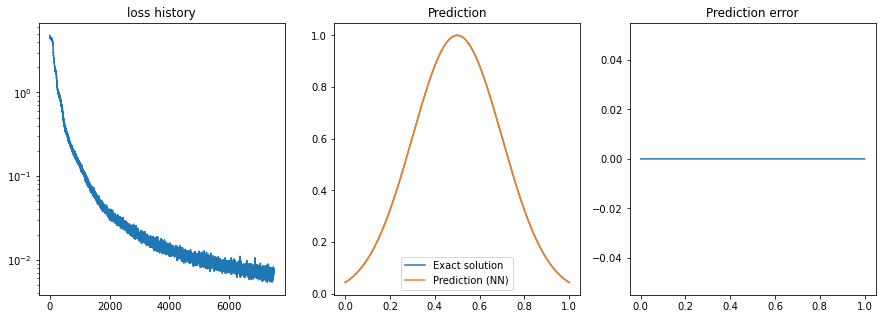

In [308]:
solver.network.plot(0., 0.5, 0.08)

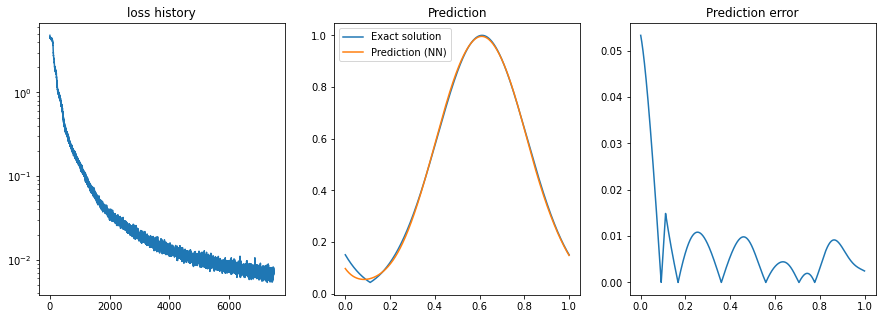

In [307]:
solver.network.plot(0.1111111111, 0.5, 0.08)

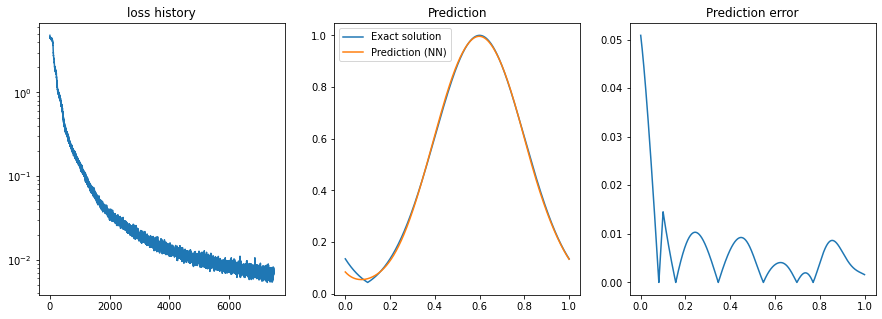

In [309]:
solver.network.plot(0.1, 0.5, 0.08)

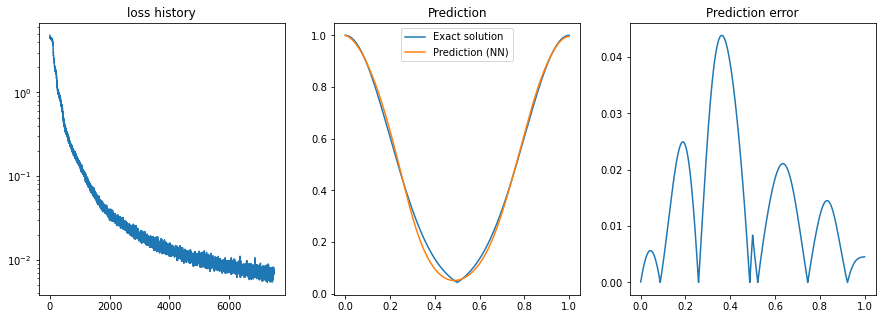

In [310]:
solver.network.plot(0.5, 0.5, 0.08)

In [304]:
import torch

x_close = torch.tensor([[1.0],
                       [0.0],
                       [0.25],
                       [0.5]], dtype=torch.float32)
                       
solver.network.predict_u_from_torch(x_close, 0.6666666, 0.5, 0.09)



tensor([[0.7381],
        [0.7632],
        [0.9205],
        [0.2505]], dtype=torch.float64, grad_fn=<AddBackward0>)

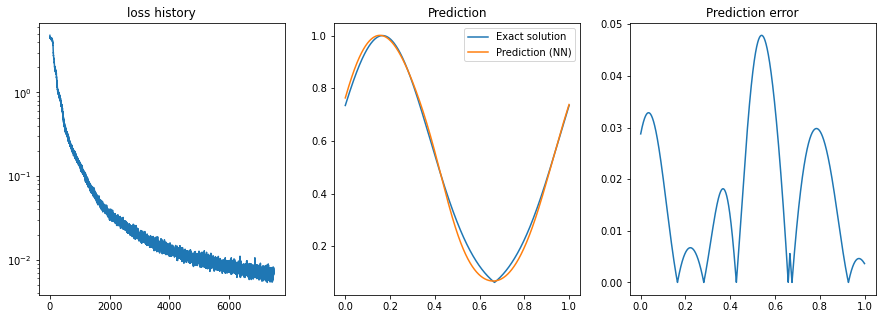

In [305]:
solver.network.plot(0.6666666, 0.5, 0.09)

deep [0.06217652 0.49935179 1.         0.49935179 0.06217652]
exact [0.06217652 0.49935179 1.         0.49935179 0.06217652]
u [0.06217652 0.49935179 1.         0.49935179 0.06217652]


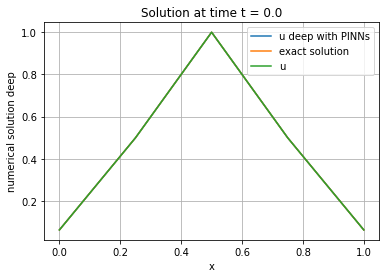

deep [ 1.40581533  2.19325263 15.4034539  13.22996515  1.40581533]
exact [0.18630241 0.23482785 0.87181833 0.80707821 0.18630241]
u [0.21456007 0.26556941 0.83781434 0.77731813 0.21456007]


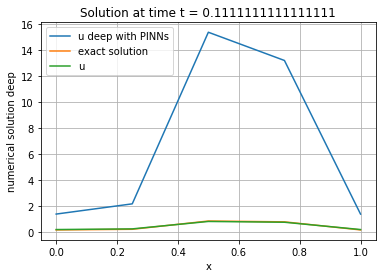

deep [ 52.91248795  -1.43684918  84.91534074 191.86416203  52.91248795]
exact [0.42428969 0.08393529 0.57770216 0.99146326 0.42428969]
u [0.53888581 0.12904136 0.59300458 0.87396894 0.53888581]


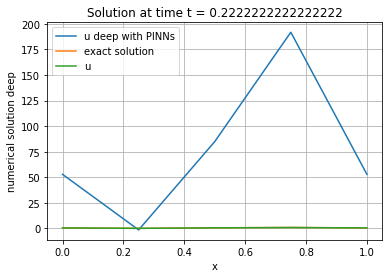

deep [ 884.24401917   -7.20737338  168.08731502 2441.94735335  884.24401917]
exact [0.73444367 0.14529163 0.29096046 0.92574127 0.73444367]
u [0.80157075 0.14976748 0.3465723  0.79940979 0.80157075]


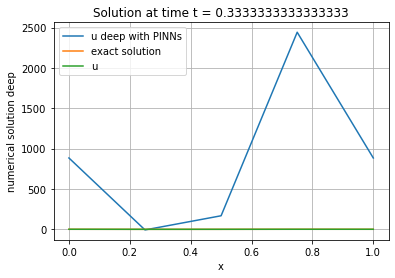

deep [16600.26336276  1122.47140108  -179.26707634 16302.08760319
 16600.26336276]
exact [0.96628781 0.35438196 0.11138224 0.65698373 0.96628781]
u [0.89966257 0.29777134 0.19227055 0.61177944 0.89966257]


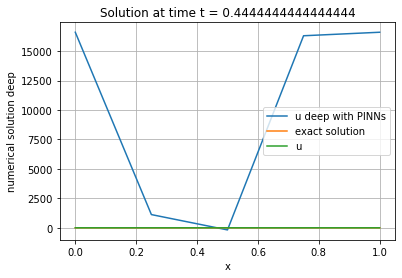

deep [260843.98307964  60695.32128879  -2072.81414236  47326.23702033
 260843.98307964]
exact [0.96628781 0.65698373 0.11138224 0.35438196 0.96628781]
u [0.8190323  0.49551371 0.17604497 0.40254931 0.8190323 ]


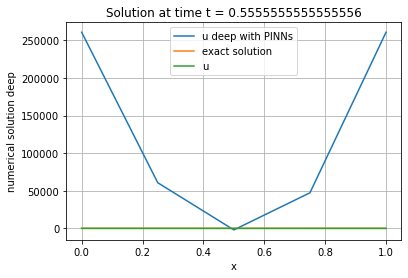

deep [1857805.77216004 1947840.14181806   47046.33785108   17657.72696162
 1857805.77216004]
exact [0.73444367 0.92574127 0.29096046 0.14529163 0.73444367]
u [0.61889348 0.65766932 0.28284008 0.25726548 0.61889348]


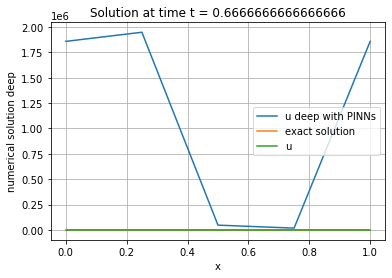

deep [ 4675520.09755039 17983280.17310379  7842905.91947417  -209750.91700912
  4675520.09755039]
exact [0.42428969 0.99146326 0.57770216 0.08393529 0.42428969]
u [0.39633667 0.72607142 0.45165902 0.22308489 0.39633667]


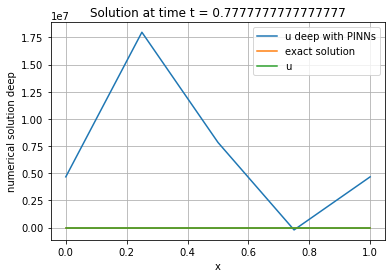

deep [-7.29740919e+04  1.03140006e+08  2.28454399e+08  8.94240522e+06
 -7.29740919e+04]
exact [0.18630241 0.80707821 0.87181833 0.23482785 0.18630241]
u [0.24223429 0.68837628 0.60659758 0.29622593 0.24223429]


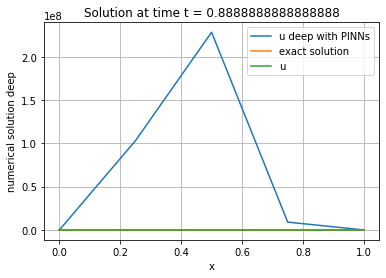

deep [-5.19628095e+07  3.31951897e+08  2.52216748e+09  7.82597988e+08
 -5.19628095e+07]
exact [0.06217652 0.49935179 1.         0.49935179 0.06217652]
u [0.20650436 0.57581782 0.6889577  0.43134487 0.20650436]


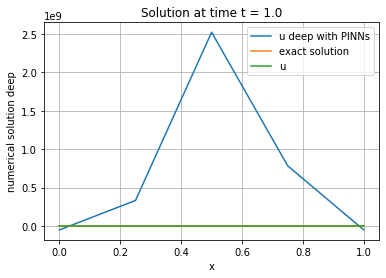

In [306]:
for i in range(solver.nt):
    solver.plot_solution_deep(i)